# Load Feature Extraction of JAAD

In [1]:
# === 1. Setup and Imports ===
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx
import torch

# Set plotting style for better aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

print("Libraries imported successfully.")
print("Ready to load data from /kaggle/input/.")

Libraries imported successfully.
Ready to load data from /kaggle/input/.


In [2]:
# === 2. Load the Data ===

# IMPORTANT: Replace '<your-dataset-name>' with the actual name of your Kaggle dataset.
# For example, if your dataset is named 'jaad-ped-features', the path would be:
# '/kaggle/input/jaad-ped-features/jaad_extracted_features.pkl'
FILE_PATH = '/kaggle/input/jaad-feature-extraction/jaad_extracted_features.pkl'

try:
    with open(FILE_PATH, "rb") as f:
        data = pickle.load(f)
    print(f"Successfully loaded data from: {FILE_PATH}")
except FileNotFoundError:
    print("---! ERROR !---")
    print(f"File not found at '{FILE_PATH}'.")
    print("Please check the following:")
    print("1. Did you add your dataset to the notebook using the '+ Add data' button?")
    print("2. Is the dataset name in the FILE_PATH variable correct?")
    # List the contents of /kaggle/input/ to help the user debug
    print("\nAvailable directories in /kaggle/input/:")
    for dirname in os.listdir('/kaggle/input/'):
        print(f"- {dirname}")
    data = None # Ensure data is None if loading fails

if data:
    # --- Initial Inspection ---
    video_ids = list(data.keys())
    print(f"\nTotal number of videos: {len(video_ids)}")

    # Let's inspect the first video's data
    sample_video_id = video_ids[0]
    print(f"\nInspecting data for '{sample_video_id}':")

    ped_map = data[sample_video_id]
    print(f"  - Pedestrian ID keys found: {list(ped_map.keys())}")
    # As documented, the ped_id key is 'None'

    frames_data = ped_map[None]
    frame_indices = list(frames_data.keys())
    print(f"  - Number of frames: {len(frame_indices)}")
    print(f"  - Frame indices start at: {min(frame_indices)} and end at: {max(frame_indices)}")


    # Display the first frame's feature dictionary
    sample_frame_idx = min(frame_indices)
    print(f"\nFeatures for frame {sample_frame_idx}:")
    for key, value in frames_data[sample_frame_idx].items():
        print(f"  - {key}: {value}")

Successfully loaded data from: /kaggle/input/jaad-feature-extraction/jaad_extracted_features.pkl

Total number of videos: 320

Inspecting data for 'video_0001':
  - Pedestrian ID keys found: [None]
  - Number of frames: 70
  - Frame indices start at: 0 and end at: 69

Features for frame 0:
  - F1_Motion: undefined (insufficient frames)
  - F2_Proximity_px: 0.0
  - F2_IsNearRoad: True
  - F3_Distance_m: 7.142857142857143
  - F4_Orientation_deg: -0.9908057451248169
  - F5_Gaze: {'vector': [1.058837890625, 3.96221923828125], 'angle_2d': 75.03826}


# Flatten to a DataFrame

In [3]:
# === 3. Flatten to a DataFrame ===
if data:
    rows = []
    for vid, ped_map in data.items():
        for ped_id, frames in ped_map.items(): # ped_id is always None here
            for fr_idx, features in frames.items():
                # Safely unpack the nested 'F5_Gaze' dictionary
                gaze = features.get("F5_Gaze") or {}
                gaze_vector = gaze.get("vector", [None, None])
                
                row = {
                    "video_id": vid,
                    "ped_id": ped_id, # This will always be None
                    "frame": fr_idx,
                    "F1_Motion": features.get("F1_Motion"),
                    "F2_Proximity_px": features.get("F2_Proximity_px"),
                    "F2_IsNearRoad": features.get("F2_IsNearRoad"),
                    "F3_Distance_m": features.get("F3_Distance_m"),
                    "F4_Orientation_deg": features.get("F4_Orientation_deg"),
                    "F5_Gaze_angle_deg": gaze.get("angle_2d"),
                    "F5_Gaze_dx": gaze_vector[0],
                    "F5_Gaze_dy": gaze_vector[1],
                }
                rows.append(row)

    df = pd.DataFrame(rows)

    print("Data flattened into a DataFrame.")
    print(f"\nDataFrame shape: {df.shape}")
    print("\nDataFrame Info:")
    df.info()

    print("\nDataFrame Head:")
    display(df.head())
else:
    print("Data was not loaded, skipping DataFrame creation.")

Data flattened into a DataFrame.

DataFrame shape: (60941, 11)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60941 entries, 0 to 60940
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   video_id            60941 non-null  object 
 1   ped_id              0 non-null      object 
 2   frame               60941 non-null  int64  
 3   F1_Motion           60941 non-null  object 
 4   F2_Proximity_px     60941 non-null  float64
 5   F2_IsNearRoad       60941 non-null  bool   
 6   F3_Distance_m       60941 non-null  float64
 7   F4_Orientation_deg  43993 non-null  float64
 8   F5_Gaze_angle_deg   43993 non-null  float64
 9   F5_Gaze_dx          43993 non-null  float64
 10  F5_Gaze_dy          43993 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(3)
memory usage: 4.7+ MB

DataFrame Head:


,video_id,ped_id,frame,F1_Motion,F2_Proximity_px,F2_IsNearRoad,F3_Distance_m,F4_Orientation_deg,F5_Gaze_angle_deg,F5_Gaze_dx,F5_Gaze_dy
0,video_0001,None,0,undefined (insufficient frames),0.0,True,7.142857,-0.990806,75.038261,1.058838,3.962219
1,video_0001,None,1,walking,0.0,True,7.112971,-1.191068,74.881187,1.043457,3.862183
2,video_0001,None,2,walking,0.0,True,7.053942,1.703707,71.455536,1.233276,3.676392
3,video_0001,None,3,walking,0.0,True,7.024793,-2.004959,66.368347,1.625366,3.714722
4,video_0001,None,4,walking,0.0,True,6.995885,-2.025640,67.943611,1.625854,4.012756


# F1. Analyze Motion Activity 

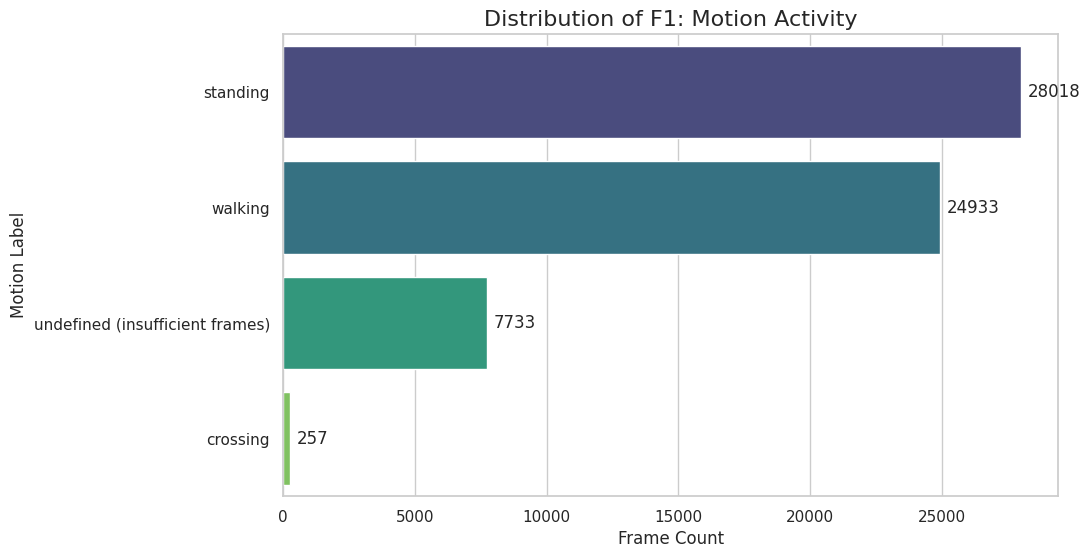

In [4]:
# === 4.1 Analyze F1_Motion ===
if 'df' in locals():
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(y=df['F1_Motion'], order=df['F1_Motion'].value_counts().index, palette='viridis')
    ax.set_title('Distribution of F1: Motion Activity')
    ax.set_xlabel('Frame Count')
    ax.set_ylabel('Motion Label')
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{int(width)}', (width, p.get_y() + p.get_height() / 2.), ha='left', va='center', xytext=(5, 0), textcoords='offset points')
    plt.show()
else:
    print("DataFrame `df` not available for analysis.")

# F2. Analyze Proximity to Road 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


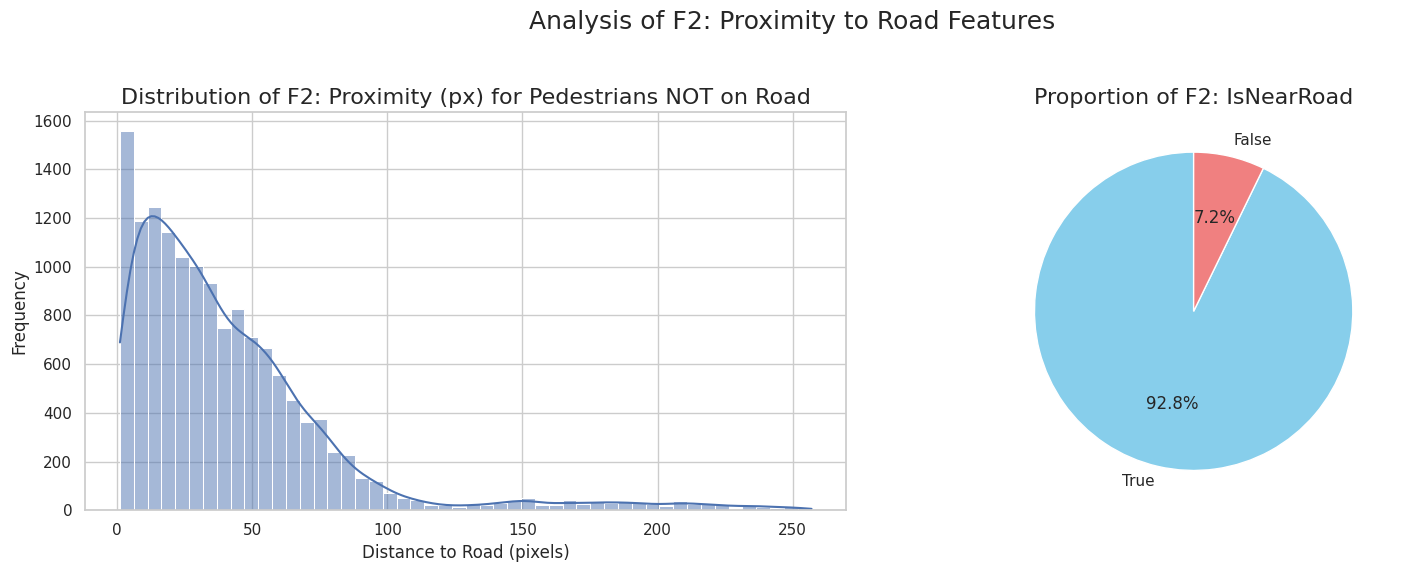

Frames where pedestrian is on the road (Proximity = 0): 46556 (76.4%)
Orientation data is available for 43993 frames.
Missing in 16948 frames (27.8%)


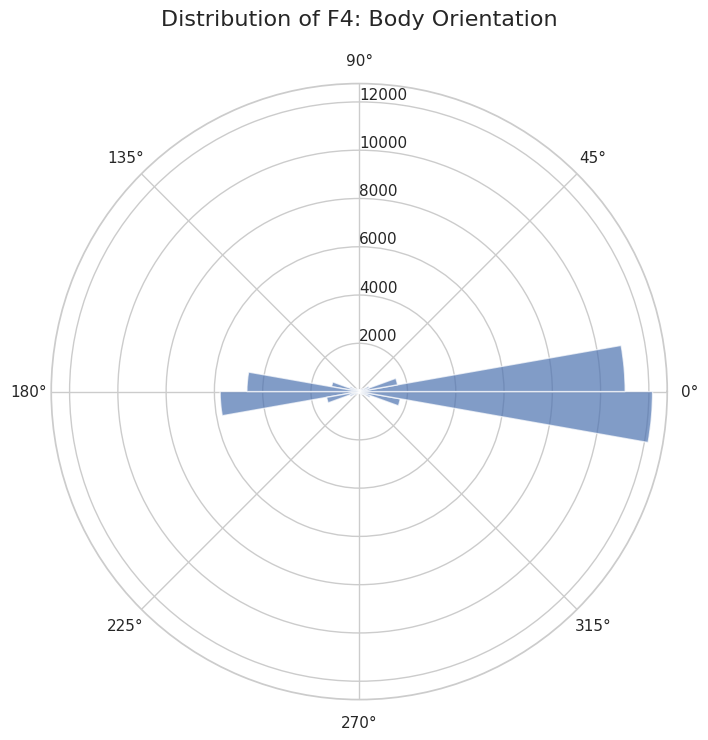

In [5]:
# === 4.2 Analyze F2_Proximity_to_Road ===
if 'df' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    off_road_data = df[df['F2_Proximity_px'] > 0]['F2_Proximity_px']
    sns.histplot(off_road_data, bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Distribution of F2: Proximity (px) for Pedestrians NOT on Road')
    axes[0].set_xlabel('Distance to Road (pixels)')
    axes[0].set_ylabel('Frequency')
    near_road_counts = df['F2_IsNearRoad'].value_counts()
    axes[1].pie(near_road_counts, labels=near_road_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
    axes[1].set_title('Proportion of F2: IsNearRoad')
    axes[1].set_ylabel('')
    plt.suptitle('Analysis of F2: Proximity to Road Features', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print(f"Frames where pedestrian is on the road (Proximity = 0): {(df['F2_Proximity_px'] == 0).sum()} ({((df['F2_Proximity_px'] == 0).sum() / len(df)):.1%})")
else:
    print("DataFrame `df` not available for analysis.")# === 4.4 Analyze F4_Orientation_deg ===
if 'df' in locals():
    orientation_data = df['F4_Orientation_deg'].dropna()
    print(f"Orientation data is available for {len(orientation_data)} frames.")
    print(f"Missing in {df['F4_Orientation_deg'].isnull().sum()} frames ({df['F4_Orientation_deg'].isnull().mean():.1%})")
    orientation_rad = np.deg2rad(orientation_data)
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    bins = np.linspace(-np.pi, np.pi, 37)
    n, _ = np.histogram(orientation_rad, bins=bins)
    centers = (bins[:-1] + bins[1:]) / 2
    width = np.pi / 18
    ax.bar(centers, n, width=width, bottom=0.0, alpha=0.7)
    ax.set_theta_zero_location('E')
    ax.set_theta_direction(1)
    ax.set_rlabel_position(90)
    ax.set_title('Distribution of F4: Body Orientation', pad=20)
    plt.show()
else:
    print("DataFrame `df` not available for analysis.")

# F3. Analyze Distance 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


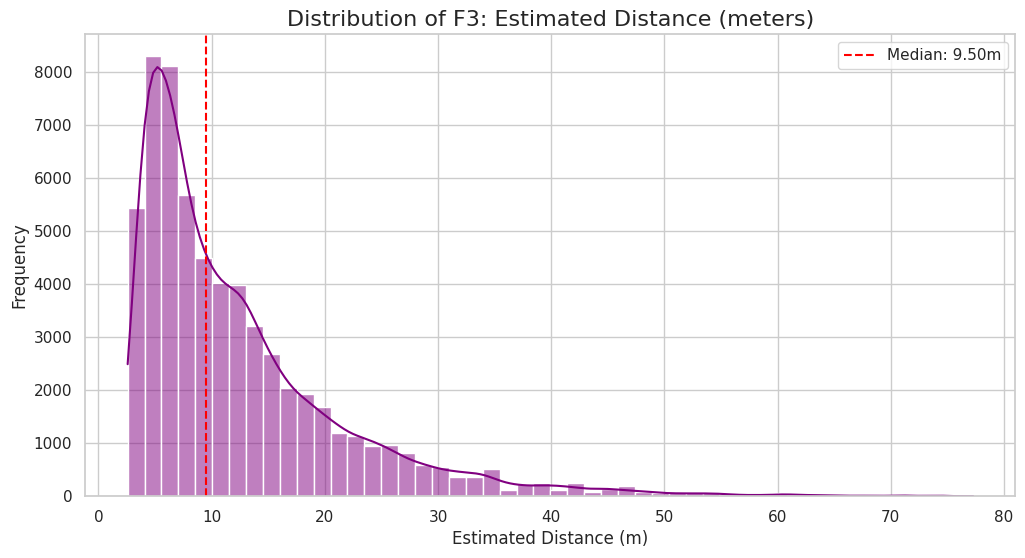

count    60941.000000
mean        12.449630
std          9.407947
min          2.575758
25%          5.802048
50%          9.497207
75%         15.740741
max         77.272727
Name: F3_Distance_m, dtype: float64

In [6]:
# === 4.3 Analyze F3_Distance_m ===
if 'df' in locals():
    plt.figure(figsize=(12, 6))
    sns.histplot(df['F3_Distance_m'], bins=50, kde=True, color='purple')
    plt.title('Distribution of F3: Estimated Distance (meters)')
    plt.xlabel('Estimated Distance (m)')
    plt.ylabel('Frequency')
    plt.axvline(df['F3_Distance_m'].median(), color='red', linestyle='--', label=f"Median: {df['F3_Distance_m'].median():.2f}m")
    plt.legend()
    plt.show()
    display(df['F3_Distance_m'].describe())
else:
    print("DataFrame `df` not available for analysis.")

# F4. Analyze Orientation 

Orientation data is available for 43993 frames.
Missing in 16948 frames (27.8%)


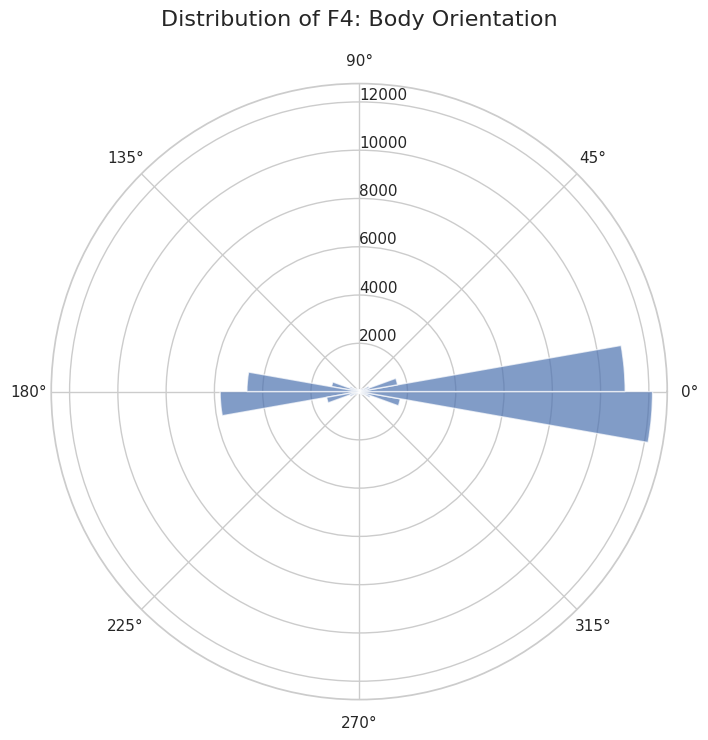

In [7]:
# === 4.4 Analyze F4_Orientation_deg ===
if 'df' in locals():
    orientation_data = df['F4_Orientation_deg'].dropna()
    print(f"Orientation data is available for {len(orientation_data)} frames.")
    print(f"Missing in {df['F4_Orientation_deg'].isnull().sum()} frames ({df['F4_Orientation_deg'].isnull().mean():.1%})")
    orientation_rad = np.deg2rad(orientation_data)
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    bins = np.linspace(-np.pi, np.pi, 37)
    n, _ = np.histogram(orientation_rad, bins=bins)
    centers = (bins[:-1] + bins[1:]) / 2
    width = np.pi / 18
    ax.bar(centers, n, width=width, bottom=0.0, alpha=0.7)
    ax.set_theta_zero_location('E')
    ax.set_theta_direction(1)
    ax.set_rlabel_position(90)
    ax.set_title('Distribution of F4: Body Orientation', pad=20)
    plt.show()
else:
    print("DataFrame `df` not available for analysis.")

# F5. Analyze Gaze

Gaze data is missing in 16948 frames (27.8%)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


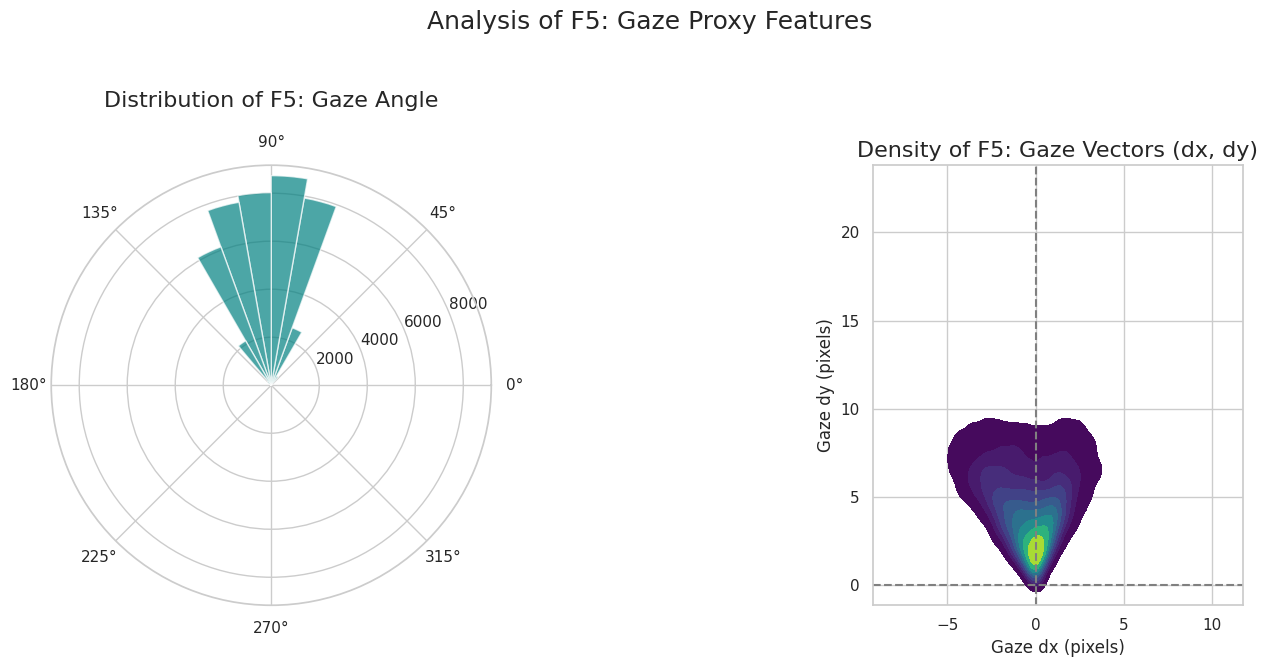

In [8]:
# === 4.5 Analyze F5_Gaze ===
if 'df' in locals():
    print(f"Gaze data is missing in {df['F5_Gaze_angle_deg'].isnull().sum()} frames "
          f"({df['F5_Gaze_angle_deg'].isnull().mean():.1%})")
    fig = plt.figure(figsize=(16, 7))
    ax1 = fig.add_subplot(121, polar=True)
    gaze_angle_data = df['F5_Gaze_angle_deg'].dropna()
    gaze_angle_rad = np.deg2rad(gaze_angle_data)
    bins = np.linspace(0, 2*np.pi, 37)
    n, _ = np.histogram(gaze_angle_rad, bins=bins)
    centers = (bins[:-1] + bins[1:]) / 2
    width = np.pi / 18
    ax1.bar(centers, n, width=width, bottom=0.0, alpha=0.7, color='teal')
    ax1.set_title('Distribution of F5: Gaze Angle', pad=20)
    ax1.set_theta_zero_location('E')
    ax2 = fig.add_subplot(122)
    gaze_vectors = df[['F5_Gaze_dx', 'F5_Gaze_dy']].dropna()
    sns.kdeplot(data=gaze_vectors, x='F5_Gaze_dx', y='F5_Gaze_dy', fill=True, cmap="viridis", ax=ax2)
    ax2.set_title('Density of F5: Gaze Vectors (dx, dy)')
    ax2.set_xlabel('Gaze dx (pixels)')
    ax2.set_ylabel('Gaze dy (pixels)')
    ax2.axhline(0, color='grey', linestyle='--')
    ax2.axvline(0, color='grey', linestyle='--')
    ax2.set_aspect('equal', adjustable='box')
    plt.suptitle('Analysis of F5: Gaze Proxy Features', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("DataFrame `df` not available for analysis.")

# Linguistic Transformation

In [9]:
# === 5.1 Implement Linguistic Transformation (IMPROVED) ===
if 'df' in locals():
    print("Applying linguistic transformation to create ontology-based features...")
    df_ontology = df.copy()

    df_ontology['Ontology_Motion'] = df_ontology['F1_Motion']
    df_ontology['Ontology_Proximity'] = np.where(df_ontology['F2_IsNearRoad'] == True, 'NearRoad', 'FarFromRoad')

    # --- IMPROVEMENT: Use data-driven quantile-based binning for Distance ---
    # This creates 3 bins with a roughly equal number of samples, which is better for training.
    try:
        df_ontology['Ontology_Distance'] = pd.qcut(df_ontology['F3_Distance_m'].dropna(), 
                                                 q=3, 
                                                 labels=['NearToEgoVeh', 'MediumDistToEgoVeh', 'FarToEgoVeh'],
                                                 duplicates='drop')
        print("\nDistribution for data-driven 'Ontology_Distance' bins:")
        print(df_ontology['Ontology_Distance'].value_counts(normalize=True))
    except ValueError as e:
        print(f"\nCould not perform quantile cut, falling back to fixed bins. Error: {e}")
        distance_bins = [-np.inf, 10, 30, np.inf]
        distance_labels = ['NearToEgoVeh', 'MediumDistToEgoVeh', 'FarToEgoVeh']
        df_ontology['Ontology_Distance'] = pd.cut(df_ontology['F3_Distance_m'], bins=distance_bins, labels=distance_labels)

    # F4: Orientation -> Forward, Right, Back, Left
    orientation_bins = [-180.1, -135, -45, 45, 135, 180.1]
    orientation_labels = ['FacingBack', 'FacingLeft', 'FacingForward', 'FacingRight', 'FacingBack']
    df_ontology['Ontology_Orientation'] = pd.cut(df_ontology['F4_Orientation_deg'], bins=orientation_bins, labels=orientation_labels, ordered=False)
    df_ontology['Ontology_Orientation'] = df_ontology['Ontology_Orientation'].cat.add_categories('Unknown').fillna('Unknown')
    
    # F5: Gaze -> GazeForward, GazeRight, GazeLeft
    gaze_bins = [-0.1, 60, 120, 180.1]
    gaze_labels = ['GazeRight', 'GazeForward', 'GazeLeft']
    df_ontology['Ontology_Gaze'] = pd.cut(df_ontology['F5_Gaze_angle_deg'], bins=gaze_bins, labels=gaze_labels, ordered=False)
    df_ontology['Ontology_Gaze'] = df_ontology['Ontology_Gaze'].cat.add_categories('Unknown').fillna('Unknown')

    df_ontology['Ontology_Action'] = np.where(df_ontology['F1_Motion'] == 'crossing', 'CrossingRoad', 'NotCrossing')
    df_ontology['PedInstanceID'] = df_ontology['video_id'] + '_' + df_ontology['frame'].astype(str)
    
    print("\nTransformation complete. New ontology columns added.")
    ontology_cols = [
        'PedInstanceID', 'Ontology_Action', 'Ontology_Motion', 'Ontology_Proximity', 
        'Ontology_Distance', 'Ontology_Orientation', 'Ontology_Gaze'
    ]
    display(df_ontology[ontology_cols].head())
else:
    print("DataFrame `df` not available for transformation.")

Applying linguistic transformation to create ontology-based features...

Distribution for data-driven 'Ontology_Distance' bins:
Ontology_Distance
MediumDistToEgoVeh    0.335045
NearToEgoVeh          0.333864
FarToEgoVeh           0.331091
Name: proportion, dtype: float64

Transformation complete. New ontology columns added.


,PedInstanceID,Ontology_Action,Ontology_Motion,Ontology_Proximity,Ontology_Distance,Ontology_Orientation,Ontology_Gaze
0,video_0001_0,NotCrossing,undefined (insufficient frames),NearRoad,MediumDistToEgoVeh,FacingForward,GazeForward
1,video_0001_1,NotCrossing,walking,NearRoad,MediumDistToEgoVeh,FacingForward,GazeForward
2,video_0001_2,NotCrossing,walking,NearRoad,MediumDistToEgoVeh,FacingForward,GazeForward
3,video_0001_3,NotCrossing,walking,NearRoad,MediumDistToEgoVeh,FacingForward,GazeForward
4,video_0001_4,NotCrossing,walking,NearRoad,MediumDistToEgoVeh,FacingForward,GazeForward


# Knowledge Graph Creation

--- Visualizing Knowledge Graph for a 'CrossingRoad' instance ---


video_id                        video_0066
ped_id                                None
frame                                   47
F1_Motion                         crossing
F2_Proximity_px                       29.0
F2_IsNearRoad                         True
F3_Distance_m                    12.408759
F4_Orientation_deg               36.959576
F5_Gaze_angle_deg                71.620949
F5_Gaze_dx                        0.580768
F5_Gaze_dy                        1.747986
Ontology_Motion                   crossing
Ontology_Proximity                NearRoad
Ontology_Distance       MediumDistToEgoVeh
Ontology_Orientation         FacingForward
Ontology_Gaze                  GazeForward
Ontology_Action               CrossingRoad
PedInstanceID                video_0066_47
Name: 11067, dtype: object

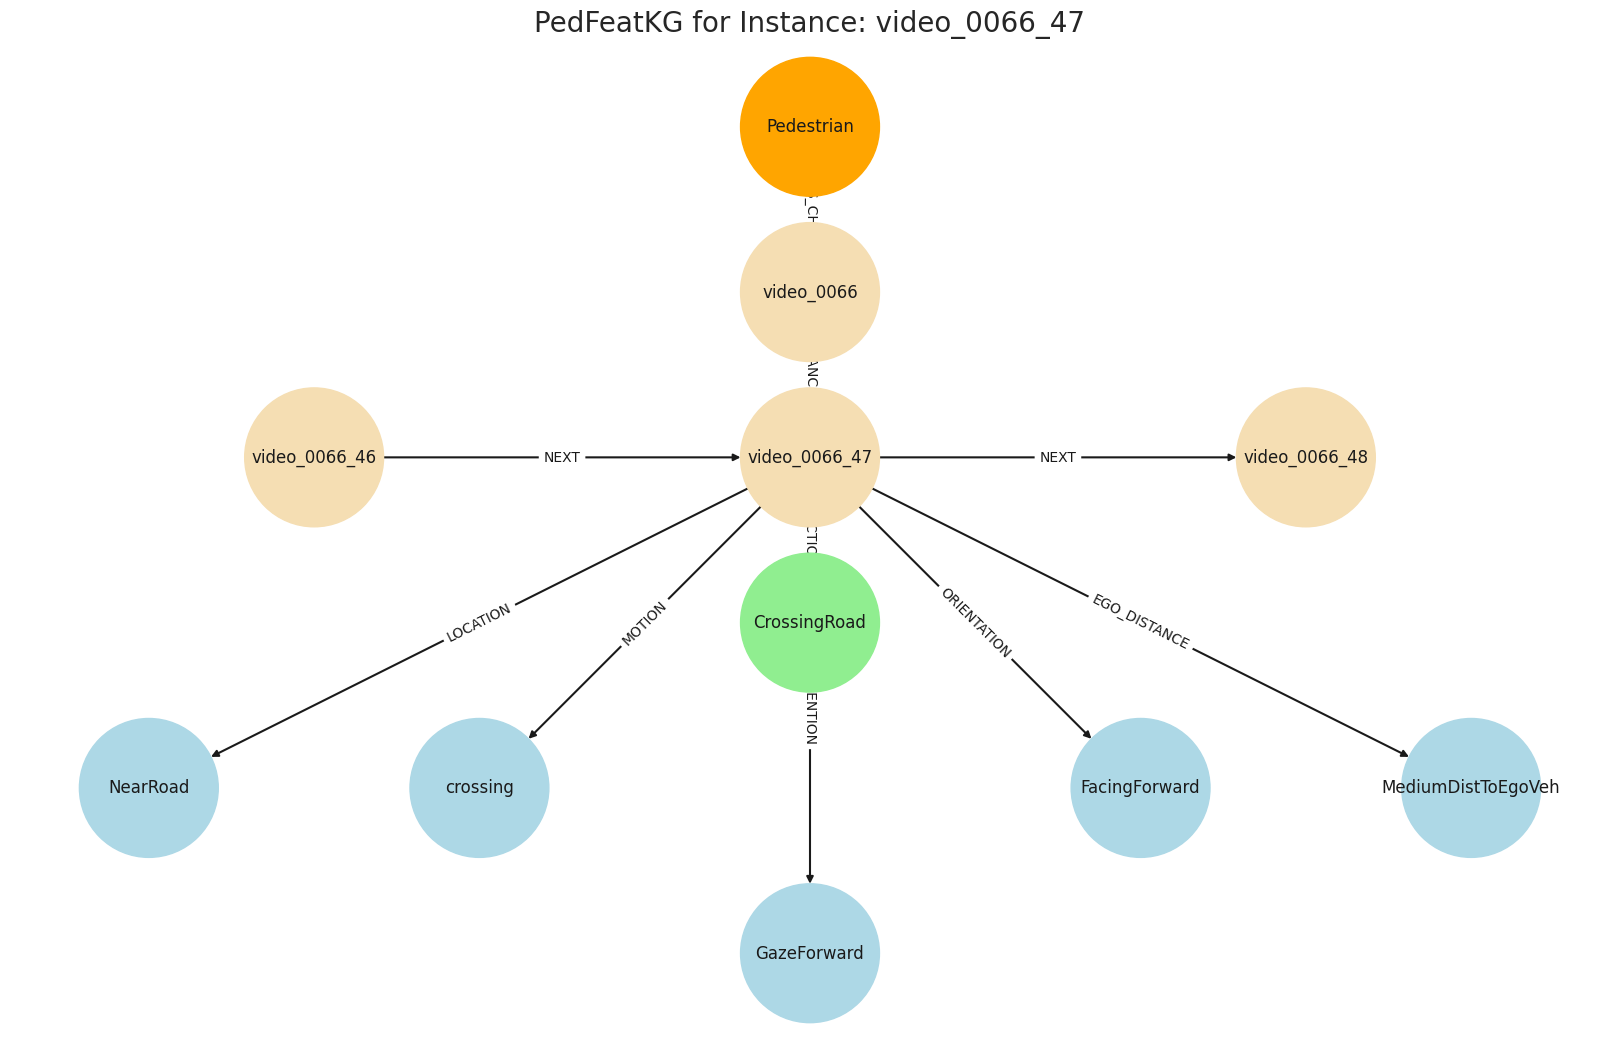

In [10]:
# === 6.1 Build and Visualize the Knowledge Graph ===
def draw_pedestrian_kg(instance_series):
    G = nx.DiGraph()
    video_id, frame = instance_series['video_id'], instance_series['frame']
    ped_class_node, video_id_node = "Pedestrian", video_id
    instance_id_node = instance_series['PedInstanceID']
    prev_instance_node, next_instance_node = f"{video_id}_{frame-1}", f"{video_id}_{frame+1}"
    
    nodes_to_add = {
        ped_class_node: ('Pedestrian', 'orange'), video_id_node: (video_id, '#f5deb3'),
        instance_id_node: (instance_id_node, '#f5deb3'), prev_instance_node: (prev_instance_node, '#f5deb3'),
        next_instance_node: (next_instance_node, '#f5deb3'),
        instance_series['Ontology_Action']: (instance_series['Ontology_Action'], 'lightgreen'),
        instance_series['Ontology_Motion']: (instance_series['Ontology_Motion'], 'lightblue'),
        instance_series['Ontology_Proximity']: (instance_series['Ontology_Proximity'], 'lightblue'),
        instance_series['Ontology_Distance']: (instance_series['Ontology_Distance'], 'lightblue'),
        instance_series['Ontology_Orientation']: (instance_series['Ontology_Orientation'], 'lightblue'),
        instance_series['Ontology_Gaze']: (instance_series['Ontology_Gaze'], 'lightblue'),
    }
    for node, (label, color) in nodes_to_add.items():
        if pd.notna(node): G.add_node(node, label=label, color=color)
    
    edges_to_add = [
        (ped_class_node, video_id_node, 'HAS_CHILD'), (video_id_node, instance_id_node, 'INSTANCE_OF'),
        (prev_instance_node, instance_id_node, 'NEXT'), (instance_id_node, next_instance_node, 'NEXT'),
        (instance_id_node, instance_series['Ontology_Action'], 'ACTION'),
        (instance_id_node, instance_series['Ontology_Motion'], 'MOTION'),
        (instance_id_node, instance_series['Ontology_Proximity'], 'LOCATION'),
        (instance_id_node, instance_series['Ontology_Distance'], 'EGO_DISTANCE'),
        (instance_id_node, instance_series['Ontology_Orientation'], 'ORIENTATION'),
        (instance_id_node, instance_series['Ontology_Gaze'], 'ATTENTION'),
    ]
    for u, v, label in edges_to_add:
        if pd.notna(v) and u in G and v in G: G.add_edge(u, v, label=label)

    plt.figure(figsize=(16, 10))
    pos = {n: (x, y) for n, (x, y) in zip(nodes_to_add.keys(), [
        (0.5, 1.0), (0.5, 0.8), (0.5, 0.6), (0.2, 0.6), (0.8, 0.6), (0.5, 0.4),
        (0.3, 0.2), (0.1, 0.2), (0.9, 0.2), (0.7, 0.2), (0.5, 0.0)])
    }
    node_colors = [data['color'] for _, data in G.nodes(data=True)]
    node_labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    nx.draw(G, pos, with_labels=False, node_size=10000, node_color=node_colors, node_shape='o', width=1.5)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title(f"PedFeatKG for Instance: {instance_id_node}", fontsize=20)
    plt.box(False)
    plt.show()

if 'df_ontology' in locals():
    crossing_example = df_ontology[df_ontology['Ontology_Action'] == 'CrossingRoad'].iloc[0]
    print("--- Visualizing Knowledge Graph for a 'CrossingRoad' instance ---")
    display(crossing_example)
    draw_pedestrian_kg(crossing_example)
else:
    print("Ontology DataFrame `df_ontology` not available for visualization.")

# Knowledge Graph Embedding (PyKEEN)

In [11]:
# === 7.1 Install and Import PyKEEN ===
!pip install pykeen -q
from pykeen.pipeline import pipeline
from pykeen.hpo import hpo_pipeline
from pykeen.triples import TriplesFactory
print(f"PyKEEN and dependencies imported successfully. Using PyTorch v{torch.__version__}.")

PyKEEN and dependencies imported successfully. Using PyTorch v2.6.0+cu124.


# Triples Generation

In [12]:
# === 7.2 Generate Triples and Create TriplesFactory (IMPROVED) ===
if 'df_ontology' in locals():
    print("Generating triples using an efficient, vectorized approach...")
    
    # 1. Hierarchical Triples
    hierarchical_triples = [('Pedestrian', 'HAS_CHILD', vid) for vid in df_ontology['video_id'].unique()]

    # 2. Instance and Sequential Triples
    instance_triples = df_ontology[['video_id', 'PedInstanceID']].apply(
        lambda row: (row['video_id'], 'INSTANCE_OF', row['PedInstanceID']), axis=1).tolist()
    
    df_ontology['PrevInstanceID'] = df_ontology['video_id'] + '_' + (df_ontology['frame'] - 1).astype(str)
    sequential_triples = df_ontology[['PrevInstanceID', 'PedInstanceID']].apply(
        lambda row: (row['PrevInstanceID'], 'NEXT', row['PedInstanceID']), axis=1).tolist()

    # 3. Feature Triples (Vectorized using pd.melt)
    feature_cols_map = {
        'Ontology_Action': 'ACTION', 'Ontology_Motion': 'MOTION',
        'Ontology_Proximity': 'LOCATION', 'Ontology_Distance': 'EGO_DISTANCE',
        'Ontology_Orientation': 'ORIENTATION', 'Ontology_Gaze': 'ATTENTION'
    }
    df_melt = df_ontology[['PedInstanceID'] + list(feature_cols_map.keys())].rename(columns=feature_cols_map)
    feature_triples_df = pd.melt(df_melt, id_vars=['PedInstanceID'], var_name='relation', value_name='tail').dropna(subset=['tail'])
    feature_triples = [tuple(x) for x in feature_triples_df.to_numpy()]

    # 4. Combine all triples and create factory
    all_triples = hierarchical_triples + instance_triples + sequential_triples + feature_triples
    triples_array = np.array(all_triples, dtype=str)
    
    print(f"Generated {len(triples_array)} triples.")

    tf = TriplesFactory.from_labeled_triples(triples_array)
    print("\nTriplesFactory created successfully.")
    print(f"Number of entities: {tf.num_entities}")
    print(f"Number of relations: {tf.num_relations}")
    
    training_factory, testing_factory, validation_factory = tf.split([0.8, 0.1, 0.1], random_state=42)
else:
    print("ERROR: Ontology DataFrame `df_ontology` is not available.")
    tf = None

Generating triples using an efficient, vectorized approach...
Generated 487848 triples.

TriplesFactory created successfully.
Number of entities: 61604
Number of relations: 9


# KGE Training (TransE)

In [16]:
# === 7.3 Train the TransE Model via the Pipeline ===
if tf:
    print("Starting PyKEEN pipeline for TransE model training...")
    
    # Configure and run the pipeline
    result = pipeline(
        training=training_factory,
        testing=testing_factory,
        validation=validation_factory,
        model='TransE',
        model_kwargs=dict(embedding_dim=100), # Corresponds to 'k' in AmpliGraph
        training_kwargs=dict(
            num_epochs=300, # Increase for better performance
            batch_size=256,
        ),
        random_seed=42,
        device='cuda', # Use 'cuda' if a GPU is available, otherwise 'cpu'
    )
    
    print("Training complete.")
    
    # The result object contains the trained model, results, and more.
    result.save_to_directory('./pykeen_transE_results')
    
    # Print the evaluation metrics
    print("\nEvaluation Metrics:")
    display(result.metric_results.to_df())

else:
    print("TriplesFactory not available for training.")
    result = None

Starting PyKEEN pipeline for TransE model training...


Training epochs on cuda:0:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/1.52k [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/48.8k [00:00<?, ?triple/s]

Training complete.

Evaluation Metrics:


,Side,Rank_type,Metric,Value
0,head,optimistic,z_geometric_mean_rank,198.044153
1,tail,optimistic,z_geometric_mean_rank,220.437469
2,both,optimistic,z_geometric_mean_rank,307.528712
3,head,realistic,z_geometric_mean_rank,198.044134
4,tail,realistic,z_geometric_mean_rank,220.437469
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.410379
221,both,realistic,adjusted_hits_at_k,0.223047
222,head,pessimistic,adjusted_hits_at_k,0.035655
223,tail,pessimistic,adjusted_hits_at_k,0.410379


# Visualization of Entity Embeddings with t-SNE

Visualizing embeddings for 19 ontology concepts...


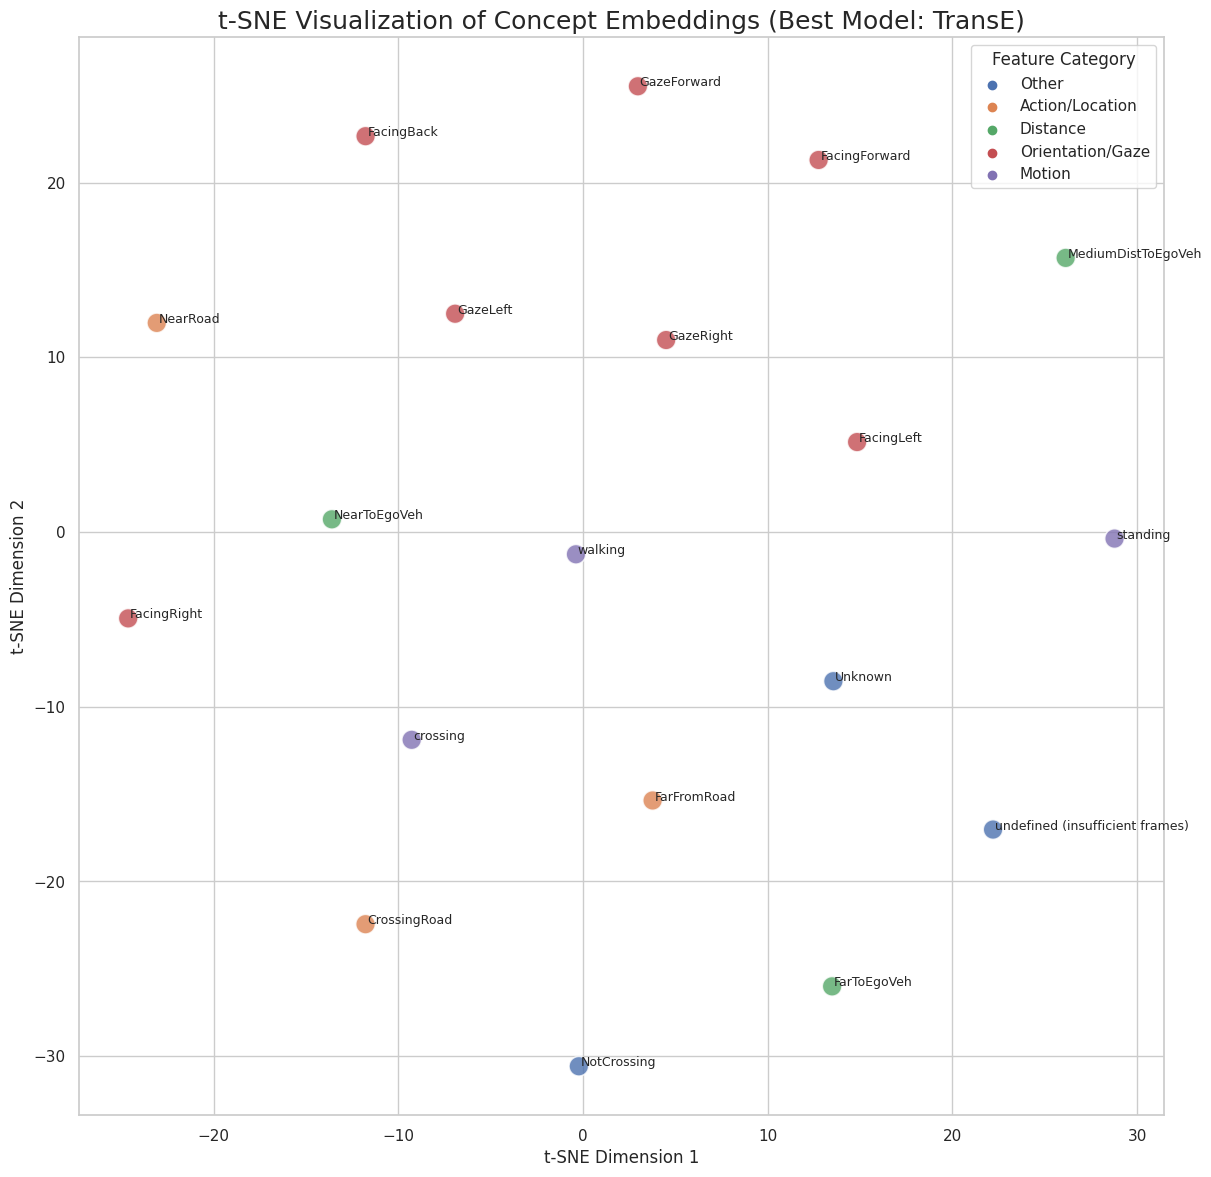

In [17]:
# === 7.4 Visualize Entity Embeddings with t-SNE ===
from sklearn.manifold import TSNE

if result:
    ontology_concepts = df_ontology[ontology_cols[1:]].stack().unique()
    ontology_concepts = [str(c) for c in ontology_concepts if pd.notna(c)]
    
    print(f"Visualizing embeddings for {len(ontology_concepts)} ontology concepts...")

    trained_model = result.model
    entity_embeddings = trained_model.entity_representations[0]

    # Get embeddings for our specific concepts
    concept_indices = [tf.entity_to_id[c] for c in ontology_concepts if c in tf.entity_to_id]
    concept_labels = [c for c in ontology_concepts if c in tf.entity_to_id]
    concept_embeddings_np = entity_embeddings(indices=torch.as_tensor(concept_indices)).detach().cpu().numpy()
    
    # Perform t-SNE reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(15, len(concept_labels)-1))
    embeddings_2d = tsne.fit_transform(concept_embeddings_np)

    df_viz = pd.DataFrame({'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'label': concept_labels})
    
    def get_category(label):
        if 'Facing' in label or 'Gaze' in label: return 'Orientation/Gaze'
        if 'Veh' in label: return 'Distance'
        if 'Road' in label: return 'Action/Location'
        if label in ['walking', 'standing', 'undefined', 'crossing']: return 'Motion'
        return 'Other'
    df_viz['category'] = df_viz['label'].apply(get_category)

    # Plot the results
    plt.figure(figsize=(14, 14))
    sns.scatterplot(data=df_viz, x='x', y='y', hue='category', s=200, palette='deep', alpha=0.8)
    for i, row in df_viz.iterrows():
        plt.text(row['x']+0.1, row['y'], row['label'], fontsize=9)
        
    best_model_name = result.model.__class__.__name__
    plt.title(f't-SNE Visualization of Concept Embeddings (Best Model: {best_model_name})', fontsize=18)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Feature Category')
    plt.grid(True)
    plt.show()
else:
    print("Model result not available, skipping visualization.")

# Save Model

In [19]:
# === 7.5 Save the Trained Model and Create a Zip Archive ===

# Make sure the necessary libraries are imported
import os
import torch
import zipfile

# Check if the 'result' object from the training cell exists
if 'result' in locals() and result is not None:
    print("Saving the trained model and creating a zip archive...")
    
    # 1. Define the output directory and filenames
    OUTPUT_DIR = "/kaggle/working/"
    MODEL_FILENAME = "transe_model_state_dict.pt"
    MODEL_FILE_PATH = os.path.join(OUTPUT_DIR, MODEL_FILENAME)
    ZIP_FILENAME = "transe_model_archive.zip"
    ZIP_FILE_PATH = os.path.join(OUTPUT_DIR, ZIP_FILENAME)
    
    # 2. Create the output directory if it doesn't already exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # 3. Save the model's state_dict to a file
    print(f"Saving model to: {MODEL_FILE_PATH}")
    torch.save(result.model.state_dict(), MODEL_FILE_PATH)
    print("...model saved successfully.")

    # 4. Create a zip archive containing the model file
    print(f"\nCreating zip archive at: {ZIP_FILE_PATH}")
    # We use a 'with' statement to ensure the zip file is properly closed.
    # 'w' mode means write mode. ZIP_DEFLATED enables compression.
    with zipfile.ZipFile(ZIP_FILE_PATH, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # The 'arcname' parameter sets the name of the file *inside* the zip archive.
        # This avoids saving the entire directory structure (/kaggle/working/...) in the zip.
        zipf.write(MODEL_FILE_PATH, arcname=MODEL_FILENAME)
    print("...zip archive created successfully.")
    
    print(f"\n✅ All files saved to {OUTPUT_DIR}")
    
    # 5. List the final contents of the output directory for verification
    print("\nContents of the output directory:")
    for file_name in os.listdir(OUTPUT_DIR):
        print(f"- {file_name}")

else:
    print("The 'result' object is not available. Please run the training cell (7.3) first.")

Saving the trained model and creating a zip archive...
Saving model to: /kaggle/working/transe_model_state_dict.pt
...model saved successfully.

Creating zip archive at: /kaggle/working/transe_model_archive.zip
...zip archive created successfully.

✅ All files saved to /kaggle/working/

Contents of the output directory:
- pykeen_best_hpo_results_TransE
- pykeen_transE_results
- transe_model_archive.zip
- .virtual_documents
- transe_model_state_dict.pt
